In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go
import plotly.offline as pyo
import datetime
import matplotlib.dates as mdates
import sys
sys.path.insert(1, '../../auxiliary_scripts')
from output_postprocessing import parse_methane_series, parse_layer_file, parse_univariate_file, parse_T_fluxes

In [2]:
layer_datafile_names={'layers': 'layers  1  1.dat'}

methane_datafile_names={'methane': 'methane_series  1  1.dat'}

univariate_datafile_names = {
                  'water_temp': 'water_temp  1  1f2.dat',
                  'soil_temp': 'soil_temp  1  1f2.dat',
                  'co2_water': 'co2_water  1  1f2.dat',
                  'ch4_water': 'methane_water  1  1f2.dat',
                  'o2_water': 'oxygen_water  1  1f2.dat',
                  'doc_water': 'DOC  1  1f2.dat',
                  'chla': 'chla  1  1f2.dat',
                  'pocl_water': 'POCL  1  1f2.dat', #live POC
                  'pocd_water': 'POCD  1  1f2.dat',
                  'phosph_water': 'phosph_water  1  1f2.dat',
                  'prodox': 'prodox  1  1f2.dat',
                  'sod': 'sod  1  1f2.dat'} #dead POC

In [3]:
run_paths=[
           '/home/amullen/LAKE_NSF/results/RabbitCreek/time_series',
           '/home/amullen/LAKE_NSF/results/Situkuyuk/time_series',
           '/home/amullen/LAKE_NSF/results/TKL524/time_series',
           '/home/amullen/LAKE_NSF/results/TKL884/time_series',
           '/home/amullen/LAKE_NSF/results/TKL917/time_series'
           ]

layers=[]
methane=[]
soil=[]
variables=[]
latent_heat = []

for run_path in run_paths:
    df_layer = parse_layer_file(os.path.join(run_path, layer_datafile_names['layers']))
    df_methane = parse_methane_series(os.path.join(run_path, methane_datafile_names['methane']))
    df_soil = parse_univariate_file(os.path.join(run_path, univariate_datafile_names['soil_temp']), 'soil_temp')
    df_latent_heat = parse_T_fluxes(os.path.join(run_path, 'T_fluxes  1  1.dat'))[['Date', 'latent heat flux,      W/m**2']]
    df_variables=pd.DataFrame()
    
    for var_key in univariate_datafile_names:      
            if(len(df_variables)==0):
                df_variables = parse_univariate_file(os.path.join(run_path, univariate_datafile_names[var_key]), var_key)
            else: 
                df_variables = pd.merge(df_variables, parse_univariate_file(os.path.join(run_path, univariate_datafile_names[var_key]), var_key))

    df_layer['site'] = run_path.split('/')[-2]
    df_methane['site'] = run_path.split('/')[-2]
    df_soil['site'] = run_path.split('/')[-2]
    df_variables['site'] = run_path.split('/')[-2]
    df_latent_heat['site'] = run_path.split('/')[-2]

    df_layer=df_layer.replace(-999, np.nan)
    df_methane=df_methane.replace(-999, np.nan)
    df_soil=df_soil.replace(-999, np.nan)
    df_variables=df_variables.replace(-999, np.nan)
    df_latent_heat = df_latent_heat.replace(-999, np.nan)

    layers.append(df_layer)
    methane.append(df_methane)
    soil.append(df_soil)
    variables.append(df_variables)
    latent_heat.append(df_latent_heat)

layers=pd.concat(layers)
methane=pd.concat(methane)
soil=pd.concat(soil)
variables=pd.concat(variables)
variables = variables.groupby(by=['Date', 'site']).mean().reset_index()
latent_heat=pd.concat(latent_heat)
latent_heat = latent_heat.rename(columns={'latent heat flux,      W/m**2': 'latent_heat_flux_W/m2'})

In [4]:
latent_heat.columns

Index(['Date', 'latent_heat_flux_W/m2', 'site'], dtype='object')

In [5]:
input_data = []

input_data_paths = [
    '/home/amullen/LAKE_NSF/meteo/RabbitCreek.dat',
    '/home/amullen/LAKE_NSF/meteo/Situkuyuk.dat',
    '/home/amullen/LAKE_NSF/meteo/TKL524.dat',
    '/home/amullen/LAKE_NSF/meteo/TKL884.dat',
    '/home/amullen/LAKE_NSF/meteo/TKL917.dat'
]

for in_path in input_data_paths:

    df = pd.read_csv(in_path)
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df['site'] = in_path.split('/')[-1].split('.')[0]

    df['Temp'] = df['Temp'] - 273

    input_data.append(df)

input_data = pd.concat(input_data)

# Water/Soil Layering and Thermal Plots

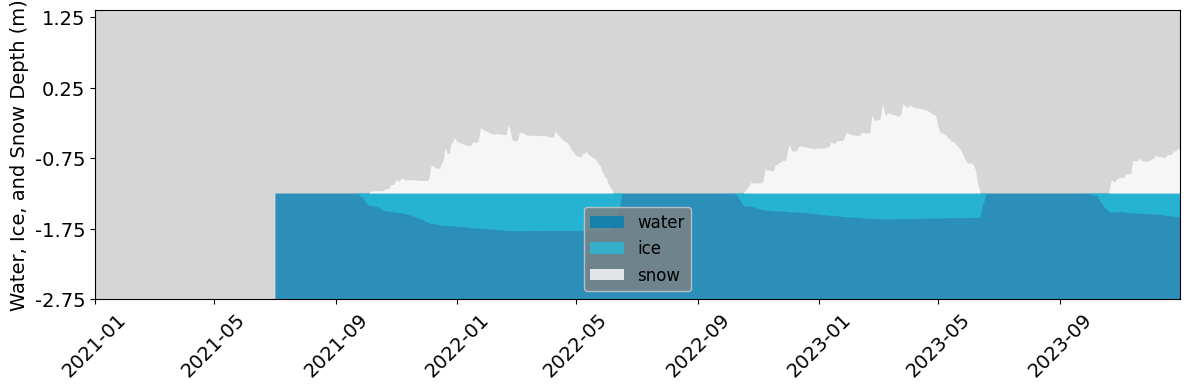

In [6]:
fig, ax = plt.subplots(figsize=(12,4))
    
ax.fill_between(df_layer['Date'], 0, df_layer['water layer thickness, m'],  
                    facecolor ='#027eb3', alpha = 0.8, label='water')
ax.fill_between(df_layer['Date'], df_layer['water layer thickness, m']-df_layer['ice layer thickness,   m'], df_layer['water layer thickness, m'],  
                    facecolor ='#25bbd9', alpha = 0.8, label='ice')
ax.fill_between(df_layer['Date'], df_layer['water layer thickness, m'], df_layer['snow layer thickness,  m'] + df_layer['water layer thickness, m'],  
                    facecolor ='white', alpha = 0.8, label='snow')

ax.set_facecolor('#d6d6d6')

    
# Customize fontsize for ticks and tick labels
ax.tick_params(axis='both', labelsize=14)

# Set specific y-axis tick labels
ax.set_yticks([0, 1, 2, 3, 4])  # Set the ticks to be at these values
ax.set_yticklabels([-2.75, -1.75, -0.75, 0.25, 1.25], fontsize=14)  # Set the tick labels with a specific fontsize

# Increase the fontsize for the legend
#ax.legend(fontsize='large')  # You can specify sizes like 'large', 'medium', 'small', or use numeric values   
ax.legend(loc='lower center',fontsize='large', facecolor = 'grey')
   
plt.ylim(0, 4.1)
plt.xticks(rotation=45)
plt.ylabel('Water, Ice, and Snow Depth (m)', fontsize=14)
plt.xlim(pd.to_datetime('2021-01-01'),pd.to_datetime('2023-12-31'))
fig.tight_layout()

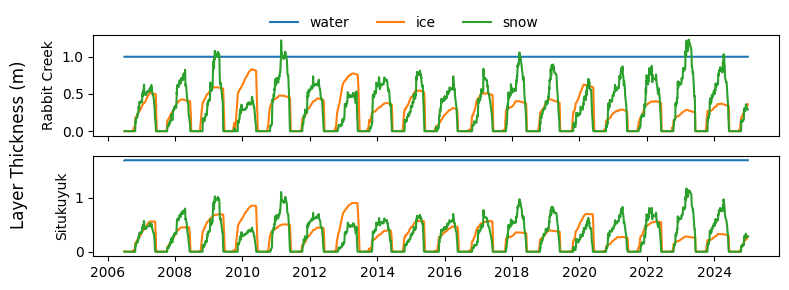

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(8,3), sharex=True)
sns.lineplot(data = layers.loc[layers['site']=='RabbitCreek'], x='Date', y='water layer thickness, m', ax=axes[0], label='water')
sns.lineplot(data = layers.loc[layers['site']=='RabbitCreek'], x='Date', y='ice layer thickness,   m', ax=axes[0], label='ice')
sns.lineplot(data = layers.loc[layers['site']=='RabbitCreek'], x='Date', y='snow layer thickness,  m', ax=axes[0], label='snow')

sns.lineplot(data = layers.loc[layers['site']=='Situkuyuk'], x='Date', y='water layer thickness, m', ax=axes[1])
sns.lineplot(data = layers.loc[layers['site']=='Situkuyuk'], x='Date', y='ice layer thickness,   m', ax=axes[1])
sns.lineplot(data = layers.loc[layers['site']=='Situkuyuk'], x='Date', y='snow layer thickness,  m', ax=axes[1])

axes[0].legend(ncol=3, frameon=False, loc=(0.25, 1))

axes[0].set_ylabel('Rabbit Creek')
axes[1].set_ylabel('Situkuyuk')

fig.supylabel('Layer Thickness (m)')

axes[1].set_xlabel('')

fig.tight_layout()
plt.savefig('figs/beaver_pond_layers.png', dpi=300)


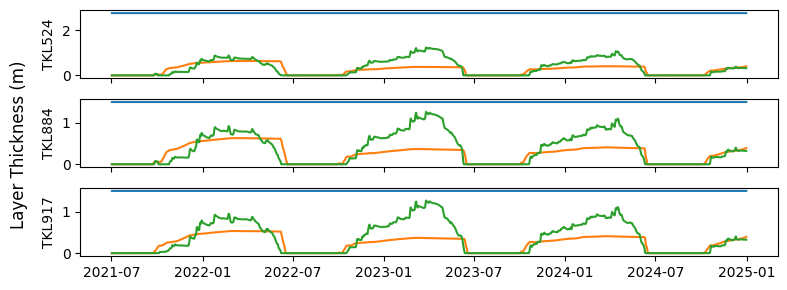

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(8,3), sharex=True)
sns.lineplot(data = layers.loc[layers['site']=='TKL524'], x='Date', y='water layer thickness, m', ax=axes[0])
sns.lineplot(data = layers.loc[layers['site']=='TKL524'], x='Date', y='ice layer thickness,   m', ax=axes[0])
sns.lineplot(data = layers.loc[layers['site']=='TKL524'], x='Date', y='snow layer thickness,  m', ax=axes[0])

sns.lineplot(data = layers.loc[layers['site']=='TKL884'], x='Date', y='water layer thickness, m', ax=axes[1])
sns.lineplot(data = layers.loc[layers['site']=='TKL884'], x='Date', y='ice layer thickness,   m', ax=axes[1])
sns.lineplot(data = layers.loc[layers['site']=='TKL884'], x='Date', y='snow layer thickness,  m', ax=axes[1])

#twinx1 = axes[1].twinx()
#sns.lineplot(data = input_data.loc[input_data['site']=='TKL884'], x='Date', y='Temp', ax=twinx1)
#twinx1.axhline(0, alpha=0.5, linestyle='--')

sns.lineplot(data = layers.loc[layers['site']=='TKL917'], x='Date', y='water layer thickness, m', ax=axes[2])
sns.lineplot(data = layers.loc[layers['site']=='TKL917'], x='Date', y='ice layer thickness,   m', ax=axes[2])
sns.lineplot(data = layers.loc[layers['site']=='TKL917'], x='Date', y='snow layer thickness,  m', ax=axes[2])


axes[0].set_ylabel('TKL524')
axes[1].set_ylabel('TKL884')
axes[2].set_ylabel('TKL917')

fig.supylabel('Layer Thickness (m)')

axes[2].set_xlabel('')

fig.tight_layout()
plt.savefig('figs/TKL_layers.png', dpi=300)

In [9]:
twater_obs = pd.read_csv('../../data/NSF_sites/in_situ/water_temp_depth_cleaned.csv', parse_dates=['time'])
twater_do_cond = pd.read_csv('../../data/NSF_sites/in_situ/temp_do_cond_cleaned.csv', parse_dates=['date'])

twater_obs = twater_obs.loc[(twater_obs['time'] >= pd.to_datetime('2024-06-05')) & (twater_obs['time'] <= pd.to_datetime('2024-08-20'))]
twater_do_cond = twater_do_cond.loc[(twater_do_cond['date'] >= pd.to_datetime('2024-06-05')) & (twater_do_cond['date'] <= pd.to_datetime('2024-08-20'))]

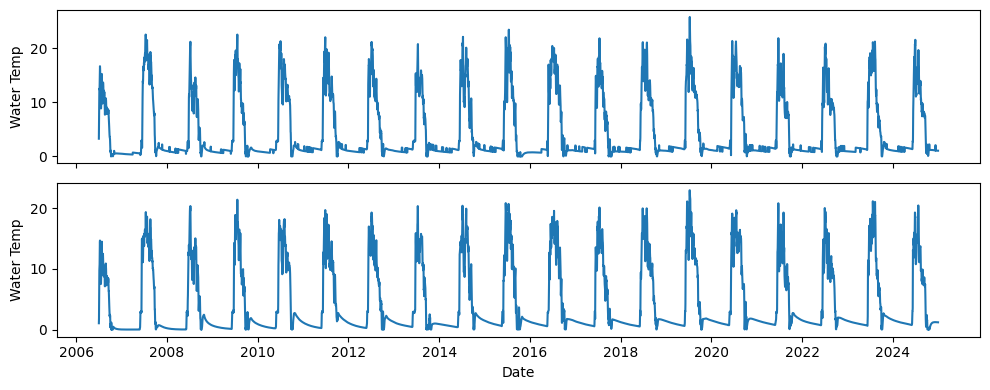

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(10,4), sharex=True)
sns.lineplot(data = variables.loc[variables['site']=='RabbitCreek'], x='Date', y='water_temp', ax=axes[0])

sns.lineplot(data = variables.loc[variables['site']=='Situkuyuk'], x='Date', y='water_temp', ax=axes[1])

axes[0].set_ylabel('Water Temp')
axes[1].set_ylabel('Water Temp')


fig.tight_layout()

Text(0, 0.5, 'Water Temp')

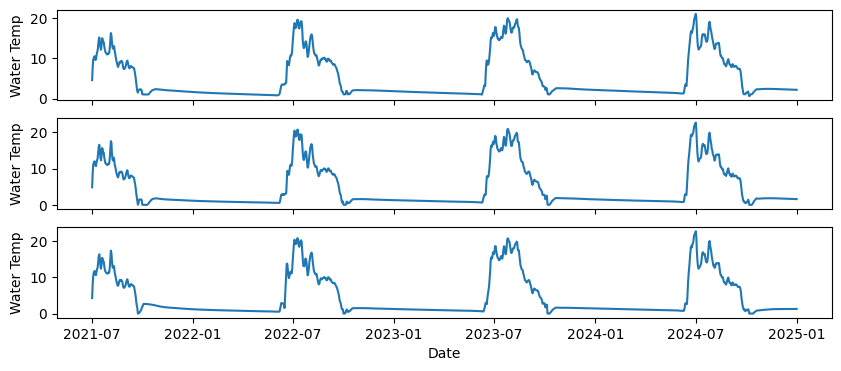

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(10,4), sharex=True)
sns.lineplot(data = variables.loc[variables['site']=='TKL524'], x='Date', y='water_temp', ax=axes[0])

sns.lineplot(data = variables.loc[variables['site']=='TKL884'], x='Date', y='water_temp', ax=axes[1])

sns.lineplot(data = variables.loc[variables['site']=='TKL917'], x='Date', y='water_temp', ax=axes[2])

axes[0].set_ylabel('Water Temp')
axes[1].set_ylabel('Water Temp')
axes[2].set_ylabel('Water Temp')

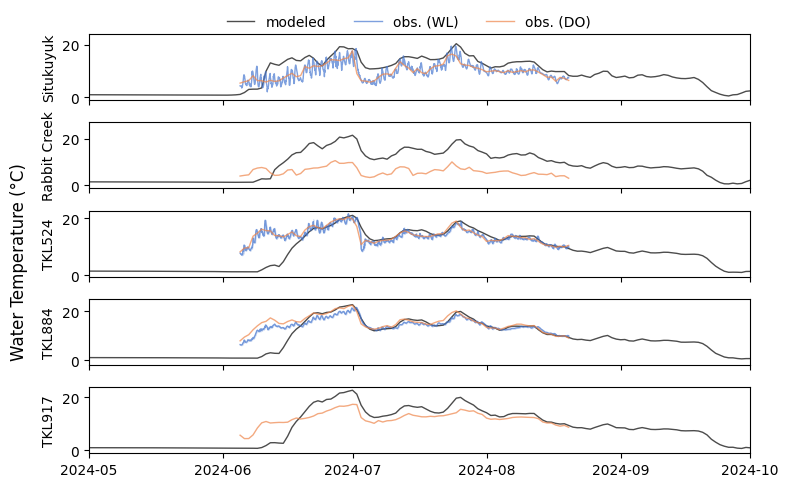

In [12]:

pal = sns.color_palette('muted', 2)
fig, axes = plt.subplots(5, 1, figsize=(8,5), sharex=True)

sns.lineplot(data = variables.loc[variables['site']=='Situkuyuk'], x='Date', y='water_temp', ax=axes[0], linewidth=1, alpha=.7, color='black', label='modeled')
sns.lineplot(data=twater_obs.loc[twater_obs['site']=='Situkuyuk'], x='time', y='temp_C', ax=axes[0], linewidth=1, alpha=.7, label='obs. (WL)', color=pal[0])
sns.lineplot(data=twater_do_cond.loc[twater_do_cond['site']=='SRBP1'], x='date', y='temp_C', ax=axes[0], linewidth=1, alpha=.7, label='obs. (DO)', color=pal[1])
#sns.lineplot(data=twater_do_cond.loc[twater_do_cond['site']=='Temperature on osmosampler SRBP1'], x='date', y='temp_C', ax=axes[1])

sns.lineplot(data = variables.loc[variables['site']=='RabbitCreek'], x='Date', y='water_temp', ax=axes[1], color='black', linewidth=1, alpha=.7)
sns.lineplot(data = twater_obs.loc[twater_obs['site']=='RabbitCreek'], x='time', y='temp_C', ax=axes[1], linewidth=1, alpha=.7, color=pal[0])
sns.lineplot(data=twater_do_cond.loc[twater_do_cond['site']=='RCBP2.1'], x='date', y='temp_C', ax=axes[1], linewidth=1, alpha=.7, color=pal[1])
#sns.lineplot(data=twater_do_cond.loc[twater_do_cond['site']=='RCBP2.2'], x='date', y='temp_C', ax=axes[0], label='obs3')

sns.lineplot(data = variables.loc[variables['site']=='TKL524'], x='Date', y='water_temp', ax=axes[2], linewidth=1, alpha=.7, color='black')
sns.lineplot(data = twater_obs.loc[twater_obs['site']=='TKL524'], x='time', y='temp_C', ax=axes[2], linewidth=1, alpha=.7, color=pal[0])
sns.lineplot(data = twater_do_cond.loc[twater_do_cond['site']=='N_TKL_524'], x='date', y='temp_C', ax=axes[2], linewidth=1, alpha=.7, color=pal[1])
#sns.lineplot(data = twater_do_cond.loc[twater_do_cond['site']=='Temperature on osmosampler TKL_524'], x='date', y='temp_C', ax=axes[2])

sns.lineplot(data = variables.loc[variables['site']=='TKL884'], x='Date', y='water_temp', ax=axes[3], linewidth=1, alpha=.7, color='black')
sns.lineplot(data = twater_obs.loc[twater_obs['site']=='TKL884'], x='time', y='temp_C', ax=axes[3], linewidth=1, alpha=.7, color=pal[0])
sns.lineplot(data = twater_do_cond.loc[twater_do_cond['site']=='N-TKL_884'], x='date', y='temp_C', ax=axes[3], linewidth=1, alpha=.7, color=pal[1])
#sns.lineplot(data = twater_do_cond.loc[twater_do_cond['site']=='Temperature on osmosampler TKL_884'], x='date', y='temp_C', ax=axes[3])

sns.lineplot(data = variables.loc[variables['site']=='TKL917'], x='Date', y='water_temp', ax=axes[4], linewidth=1, alpha=.7, color='black')
sns.lineplot(data = twater_obs.loc[twater_obs['site']=='TKL917'], x='time', y='temp_C', ax=axes[4], linewidth=1, alpha=.7, color=pal[0])
sns.lineplot(data = twater_do_cond.loc[twater_do_cond['site']=='N_TKL_917'], x='date', y='temp_C', ax=axes[4], linewidth=1, alpha=.7, color=pal[1])
#sns.lineplot(data = twater_do_cond.loc[twater_do_cond['site']=='Temperature on osmosampler TKL_917'], x='date', y='temp_C', ax=axes[4])

plt.xlim(pd.to_datetime('2024-05-01'), pd.to_datetime('2024-10-01'))

axes[0].set_ylabel('Situkuyuk')
axes[1].set_ylabel('Rabbit Creek')
axes[2].set_ylabel('TKL524')
axes[3].set_ylabel('TKL884')
axes[4].set_ylabel('TKL917')

fig.supylabel('Water Temperature (°C)')

axes[3].set_ylim(-2,25)

fig.tight_layout()

axes[4].set_xlabel('')

axes[0].legend(ncol=3, frameon=False, loc = (0.2, 1))

plt.savefig('figs/water_temp.png', dpi=300)

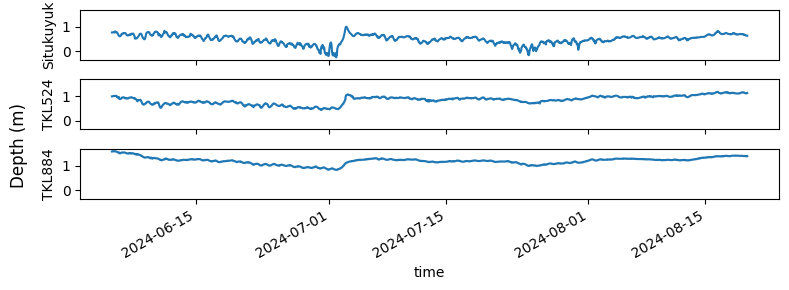

In [13]:
fig, axes=plt.subplots(3,1, figsize=(8,3), sharex=True, sharey=True)

sns.lineplot(data = twater_obs.loc[twater_obs['site']=='Situkuyuk'], x='time', y='depth_m', ax=axes[0])
sns.lineplot(data = twater_obs.loc[twater_obs['site']=='TKL524'], x='time', y='depth_m', ax=axes[1])
sns.lineplot(data = twater_obs.loc[twater_obs['site']=='TKL884'], x='time', y='depth_m', ax=axes[2])

axes[0].set_ylabel('Situkuyuk')
axes[1].set_ylabel('TKL524')
axes[2].set_ylabel('TKL884')

fig.supylabel('Depth (m)')

fig.autofmt_xdate()

fig.tight_layout()

plt.savefig('figs/water_levels.png', dpi=300)



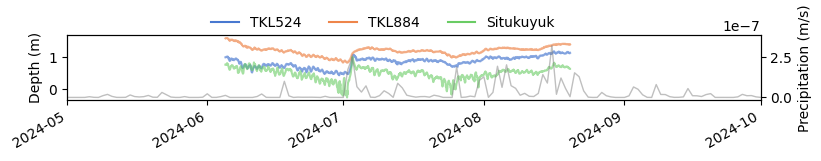

In [14]:
fig, ax=plt.subplots(figsize=(8,1.5), sharex=True, sharey=True)

sns.lineplot(data = twater_obs, x='time', y='depth_m', hue='site', palette='muted', alpha=0.6)

ax2=ax.twinx()
sns.lineplot(data = input_data.loc[input_data['site']=='Situkuyuk'], x='Date', y='Precip', ax=ax2, color='grey', linewidth=1, alpha=0.5)

ax2.set_ylabel('Precipitation (m/s)')

ax.set_ylabel('Depth (m)')

ax.set_xlabel('')

fig.autofmt_xdate()

fig.tight_layout()

ax.legend(ncol=3, frameon=False, loc = (0.2, 1), title='')

plt.xlim(pd.to_datetime('2024-05-01'), pd.to_datetime('2024-10-01'))

plt.savefig('figs/water_levels.png', dpi=300)



(19844.0, 19997.0)

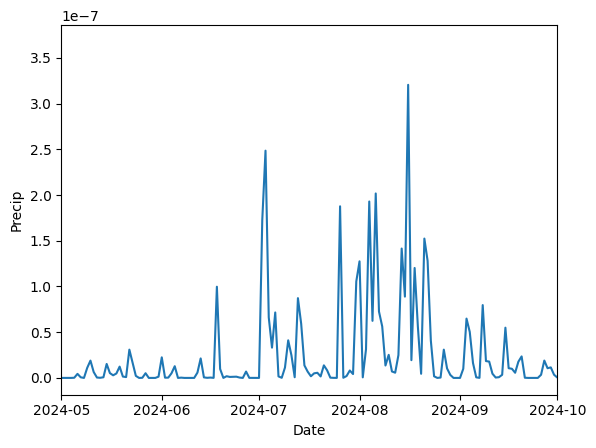

In [15]:
fig, ax = plt.subplots()

sns.lineplot(data = input_data.loc[input_data['site']=='Situkuyuk'], x='Date', y='Precip')

ax.set_xlim(pd.to_datetime('2024-05-01'), pd.to_datetime('2024-10-01'))

In [16]:
# Pivot to get 2D array: rows = depth, columns = time
pivot_RCBP = soil.loc[soil['site']=='RabbitCreek'].pivot_table(index='depth', columns='Date', values='soil_temp')
pivot_RCBP = pivot_RCBP.sort_index().sort_index(axis=1)

pivot_SRBP = soil.loc[soil['site']=='Situkuyuk'].pivot_table(index='depth', columns='Date', values='soil_temp')
pivot_SRBP = pivot_SRBP.sort_index().sort_index(axis=1)

pivot_TKL524 = soil.loc[soil['site']=='TKL524'].pivot_table(index='depth', columns='Date', values='soil_temp')
pivot_TKL524 = pivot_TKL524.sort_index().sort_index(axis=1)

pivot_TKL884 = soil.loc[soil['site']=='TKL884'].pivot_table(index='depth', columns='Date', values='soil_temp')
pivot_TKL884 = pivot_TKL884.sort_index().sort_index(axis=1)

pivot_TKL917 = soil.loc[soil['site']=='TKL917'].pivot_table(index='depth', columns='Date', values='soil_temp')
pivot_TKL917 = pivot_TKL917.sort_index().sort_index(axis=1)


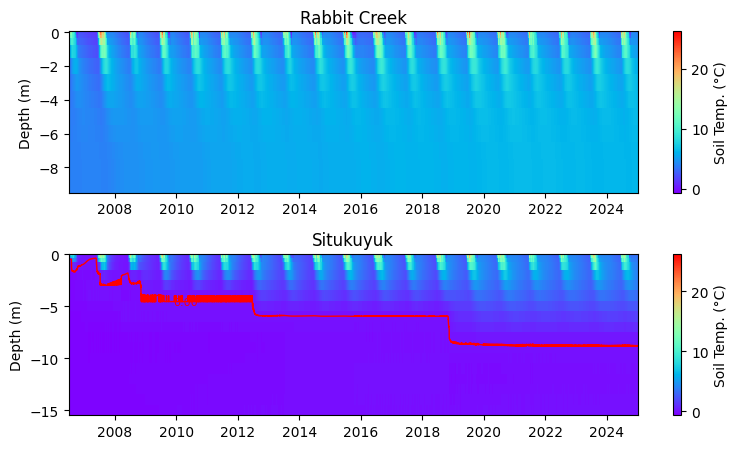

In [17]:
# Function to plot the 0 degree isotherm
def plot_isotherm(ax, pivot_data):
    # Convert column labels to datetime if they're not already
    if not isinstance(pivot_data.columns, pd.DatetimeIndex):
        pivot_data.columns = pd.to_datetime(pivot_data.columns)
    
    X, Y = np.meshgrid(pivot_data.columns, pivot_data.index)
    CS = ax.contour(X, Y, pivot_data.values, levels=[0], colors='red', linewidths=1)
    ax.clabel(CS, inline=False, fmt='%1.2f', fontsize=8)

vmin = min(pivot_RCBP.min().min(), pivot_SRBP.min().min())
vmax = max(pivot_RCBP.max().max(), pivot_SRBP.max().max())

fig, axes = plt.subplots(2, 1, figsize=(8, 5))

# First subplot
pcm1 = axes[0].pcolormesh(
    pivot_RCBP.columns, pivot_RCBP.index, pivot_RCBP.values,
    shading='auto', cmap='rainbow', vmin=vmin, vmax=vmax
)

plot_isotherm(axes[0], pivot_RCBP)
#axes[0].invert_yaxis()
axes[0].set_title('Rabbit Creek')
axes[0].set_xlabel('')
axes[0].set_ylabel('Depth (m)')
fig.colorbar(pcm1, ax=axes[0], label='Soil Temp. (°C)')

# Second subplot
pcm2 = axes[1].pcolormesh(
    pivot_SRBP.columns, pivot_SRBP.index, pivot_SRBP.values,
    shading='auto', cmap='rainbow', vmin=vmin, vmax=vmax
)
plot_isotherm(axes[1], pivot_SRBP)
#axes[1].invert_yaxis()
axes[1].set_title('Situkuyuk')
axes[1].set_xlabel('')
axes[1].set_ylabel('Depth (m)')
fig.colorbar(pcm2, ax=axes[1], label='Soil Temp. (°C)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig('figs/soil_temperatures_bp.png', dpi=300)

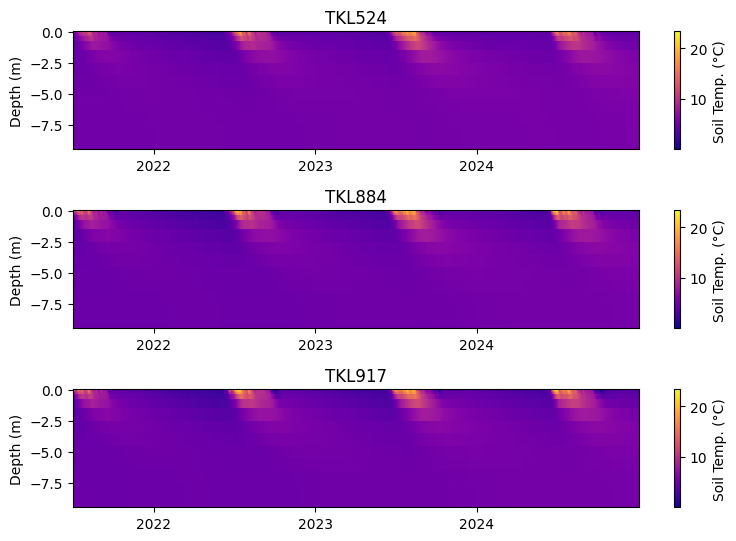

In [18]:
vmin = min(pivot_TKL524.min().min(), pivot_TKL884.min().min(), pivot_TKL917.min().min())
vmax = max(pivot_TKL524.max().max(), pivot_TKL884.max().max(), pivot_TKL917.max().max())

fig, axes = plt.subplots(3, 1, figsize=(8, 6))

# First subplot
pcm1 = axes[0].pcolormesh(
    pivot_TKL524.columns, pivot_TKL524.index, pivot_TKL524.values,
    shading='auto', cmap='plasma', vmin=vmin, vmax=vmax
)
axes[0].set_title('TKL524')
axes[0].set_xlabel('')
axes[0].set_ylabel('Depth (m)')
fig.colorbar(pcm1, ax=axes[0], label='Soil Temp. (°C)')

# Second subplot
pcm2 = axes[1].pcolormesh(
    pivot_TKL884.columns, pivot_TKL884.index, pivot_TKL884.values,
    shading='auto', cmap='plasma', vmin=vmin, vmax=vmax
)
axes[1].set_title('TKL884')
axes[1].set_xlabel('')
axes[1].set_ylabel('Depth (m)')
fig.colorbar(pcm2, ax=axes[1], label='Soil Temp. (°C)')

# Second subplot
pcm3 = axes[2].pcolormesh(
    pivot_TKL917.columns, pivot_TKL917.index, pivot_TKL917.values,
    shading='auto', cmap='plasma', vmin=vmin, vmax=vmax
)
axes[2].set_title('TKL917')
axes[2].set_xlabel('')
axes[2].set_ylabel('Depth (m)')
fig.colorbar(pcm3, ax=axes[2], label='Soil Temp. (°C)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Set major ticks to years
for ax in axes:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


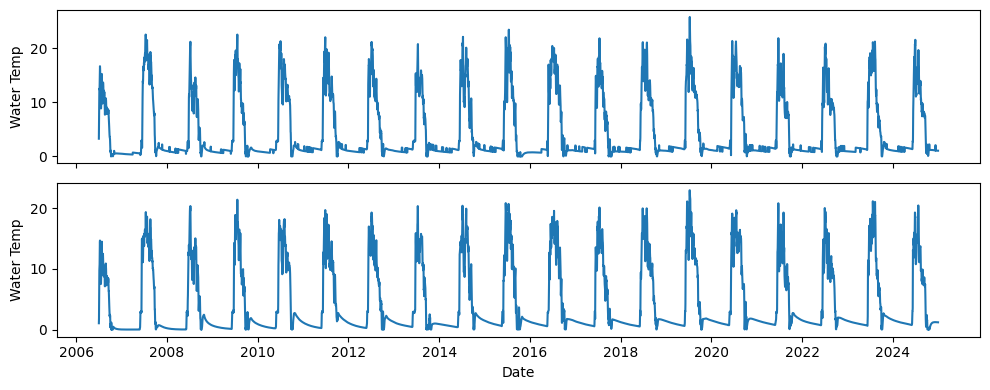

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(10,4), sharex=True)
sns.lineplot(data = variables.loc[variables['site']=='RabbitCreek'], x='Date', y='water_temp', ax=axes[0])

sns.lineplot(data = variables.loc[variables['site']=='Situkuyuk'], x='Date', y='water_temp', ax=axes[1])

axes[0].set_ylabel('Water Temp')
axes[1].set_ylabel('Water Temp')


fig.tight_layout()

# Biogeochemical Concentrations

In [20]:
twater_do_cond['site'].unique()

array(['N-TKL_884', 'N_TKL_524', 'N_TKL_917', 'RCBP2.1', 'RCBP2.2',
       'SRBP1', 'Temperature on osmosampler SRBP1',
       'Temperature on osmosampler TKL_524',
       'Temperature on osmosampler TKL_884',
       'Temperature on osmosampler TKL_917'], dtype=object)

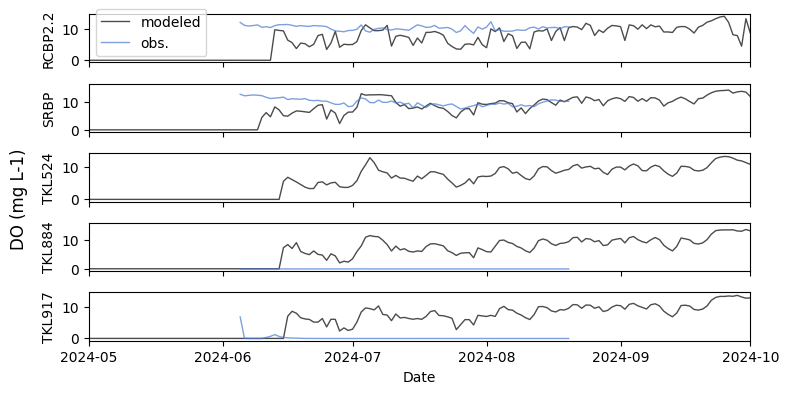

In [21]:
fig, axes = plt.subplots(5, 1, figsize=(8,4), sharex=True)

sns.lineplot(data = variables.loc[variables['site']=='RabbitCreek'], x='Date', y='o2_water', ax=axes[0], label='modeled', color='black', alpha=0.7, linewidth=1)
sns.lineplot(data=twater_do_cond.loc[twater_do_cond['site']=='RCBP2.2'], x='date', y='do_mgl', ax=axes[0], color=pal[0], alpha=0.7, linewidth=1, label='obs.')

sns.lineplot(data = variables.loc[variables['site']=='Situkuyuk'], x='Date', y='o2_water', ax=axes[1], color='black', alpha=0.7, linewidth=1)
sns.lineplot(data=twater_do_cond.loc[twater_do_cond['site']=='SRBP1'], x='date', y='do_mgl', ax=axes[1], color=pal[0], alpha=0.7, linewidth=1)

sns.lineplot(data = variables.loc[variables['site']=='TKL524'], x='Date', y='o2_water', ax=axes[2], color='black', alpha=0.7, linewidth=1)
sns.lineplot(data=twater_do_cond.loc[twater_do_cond['site']=='N-TKL_524'], x='date', y='do_mgl', ax=axes[2], color=pal[0], alpha=0.7, linewidth=1)

sns.lineplot(data = variables.loc[variables['site']=='TKL884'], x='Date', y='o2_water', ax=axes[3], color='black', alpha=0.7, linewidth=1)
sns.lineplot(data=twater_do_cond.loc[twater_do_cond['site']=='N-TKL_884'], x='date', y='do_mgl', ax=axes[3], color=pal[0], alpha=0.7, linewidth=1)

sns.lineplot(data = variables.loc[variables['site']=='TKL917'], x='Date', y='o2_water', ax=axes[4], color='black', alpha=0.7, linewidth=1)
sns.lineplot(data=twater_do_cond.loc[twater_do_cond['site']=='N_TKL_917'], x='date', y='do_mgl', ax=axes[4], color=pal[0], alpha=0.7, linewidth=1)

plt.xlim(pd.to_datetime('2024-05-01'), pd.to_datetime('2024-10-01'))

axes[0].set_ylabel('RCBP2.2')
axes[1].set_ylabel('SRBP')
axes[2].set_ylabel('TKL524')
axes[3].set_ylabel('TKL884')
axes[4].set_ylabel('TKL917')

fig.supylabel('DO (mg L-1)')


fig.tight_layout()

plt.savefig('figs/DO.png', dpi=300)

# CH4 outputs

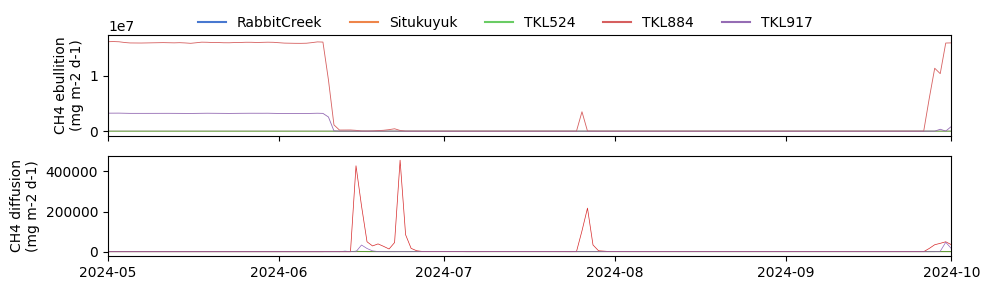

In [22]:
fig, axes = plt.subplots(2,1, figsize=(10,3), sharex=True)

sns.lineplot(data=methane, x='Date', y='methane_ebul_mg/(m**2*day)', hue='site', linewidth=0.6, palette = 'muted', ax=axes[0])

sns.lineplot(data=methane, x='Date', y='methane_turb_flux_mg/(m**2*day)', hue='site', linewidth=0.5, ax=axes[1], legend=False)

axes[0].legend(ncol=5, frameon=False, loc=(0.1,1))
axes[0].set_ylabel('CH4 ebullition\n(mg m-2 d-1)')
axes[1].set_ylabel('CH4 diffusion\n(mg m-2 d-1)')
axes[1].set_xlabel('')
axes[1].set_xlim(pd.to_datetime('2024-05-01'), pd.to_datetime('2024-10-01'))

fig.tight_layout()

plt.savefig('figs/CH4_emission.png', dpi=300)

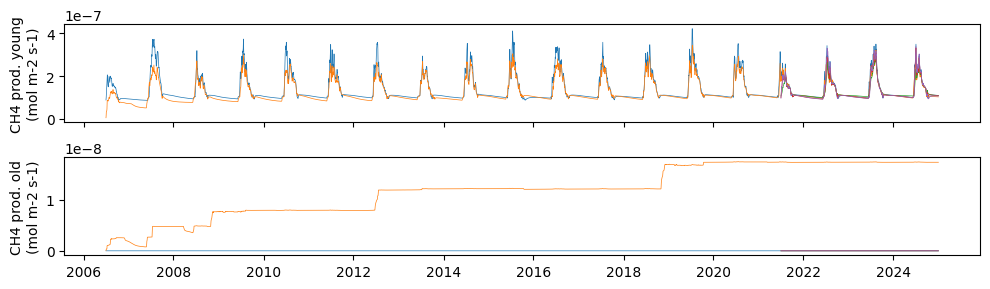

In [23]:
fig, axes = plt.subplots(2,1, figsize=(10,3), sharex=True)

sns.lineplot(data=methane.reset_index(), x='Date', y='methane_prod_young_mol/(m**2*s)', hue='site', linewidth=0.5, ax=axes[0], legend=False)

sns.lineplot(data=methane, x='Date', y='methane_prod_old_mol/(m**2*s)', hue='site', linewidth=0.5, ax=axes[1], legend=False)

axes[0].set_ylabel('CH4 prod. young\n(mol m-2 s-1)')
axes[1].set_ylabel('CH4 prod. old\n(mol m-2 s-1)')
axes[1].set_xlabel('')

fig.tight_layout()

plt.savefig('figs/CH4_production.png', dpi=300)

/tmp/ipykernel_1847/2599213177.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Cumulative CH4 emissions for 2024 by site:
       site  total_flux_g_m2
RabbitCreek     6.370694e+01
  Situkuyuk     5.712785e+01
     TKL524     5.993848e+01
     TKL884     2.971065e+06
     TKL917     7.878283e+05


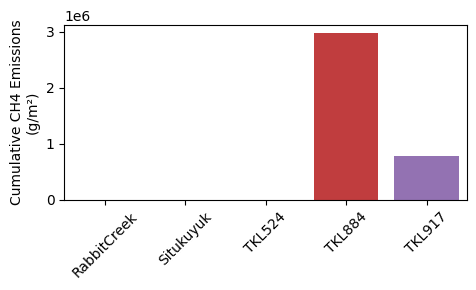

In [24]:

def calculate_cumulative_ch4(df):
    # Filter for the year 2024
    df_2024 = df[df['Date'].dt.year == 2024]
    
    # Calculate total daily flux (turbulent + ebullition)
    df_2024['total_flux'] = df_2024['methane_turb_flux_mg/(m**2*day)'] + df_2024['methane_ebul_mg/(m**2*day)']
    
    # Calculate cumulative sum for each site
    cumulative = df_2024.groupby('site')['total_flux'].sum().reset_index()
    
    # Convert from mg/m^2 to g/m^2
    cumulative['total_flux_g_m2'] = cumulative['total_flux'] / 1000
    
    return cumulative

# Calculate cumulative CH4 emissions
cumulative_ch4 = calculate_cumulative_ch4(methane)

# Display results
print("Cumulative CH4 emissions for 2024 by site:")
print(cumulative_ch4[['site', 'total_flux_g_m2']].to_string(index=False))

# Create a bar plot of the results
plt.figure(figsize=(5, 3))
sns.barplot(x='site', y='total_flux_g_m2', data=cumulative_ch4)
plt.xlabel('')
plt.ylabel('Cumulative CH4 Emissions\n(g/m²)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figs/cumulative_ch4_emissions_2024.png', dpi=300)

(0.0, 150.0)

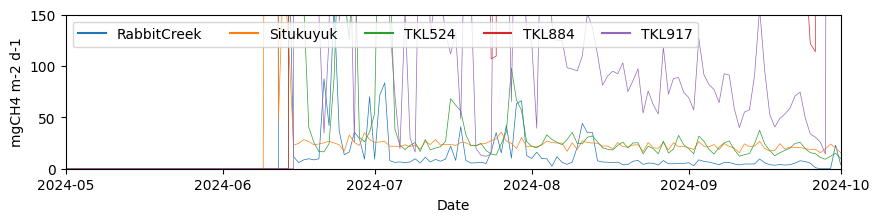

In [25]:
fig, ax = plt.subplots(figsize=(10,2))

sns.lineplot(data=methane, x='Date', y='methane_turb_flux_mg/(m**2*day)', hue='site', linewidth=0.5)
ax.legend(ncol=5)
ax.set_ylabel('mgCH4 m-2 d-1')
plt.xlim(pd.to_datetime('2024-05-01'), pd.to_datetime('2024-10-01'))
plt.ylim(0,150)

In [26]:
methane

,Date,year,month,day,hour,"talik depth, m","lake surface methane concentration, mol/m**3","lake bottom methane concentration, mol/m**3",methane_prod_young_mol/(m**2*s),methane_prod_old_mol/(m**2*s),...,ox_turb_flux_mol/(m**2*s),ox_ebul_mol/(m**2*s),methane_influx_mol/(m**2*s),methane_ebul_sc1,methane_ebul_sc2,methane_ebul_sc3,methane_ebul_sc4,methane_ebul_sc5,run_name,site
0,2006-07-02,2006,7,2,12.0,0.0,0.056238,8.534700e-02,8.796300e-08,0.0,...,4.191300e-06,1.063100e-30,0.0,0.0,0.0,0.0,0.0,1.085500e-02,time_series,RabbitCreek
1,2006-07-03,2006,7,3,12.0,0.0,0.006312,5.473100e-03,9.351800e-08,0.0,...,7.134100e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,time_series,RabbitCreek
2,2006-07-04,2006,7,4,12.0,0.0,0.001150,1.000000e-20,1.009800e-07,0.0,...,3.908500e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,time_series,RabbitCreek
3,2006-07-05,2006,7,5,12.0,0.0,0.000238,1.211800e-03,1.130700e-07,0.0,...,4.597100e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,time_series,RabbitCreek
4,2006-07-06,2006,7,6,12.0,0.0,0.000223,3.416200e-03,1.287700e-07,0.0,...,9.128300e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,time_series,RabbitCreek
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,2024-12-27,2024,12,27,12.0,0.0,2.181200,2.981500e+03,1.061700e-07,0.0,...,0.000000e+00,4.644700e-24,0.0,2906.4,3197.5,3166.4,2252.6,2.633300e+07,time_series,TKL917
1275,2024-12-28,2024,12,28,12.0,0.0,2.205600,3.017300e+03,1.061400e-07,0.0,...,0.000000e+00,4.699800e-24,0.0,2913.2,3203.8,3170.3,2242.1,2.664800e+07,time_series,TKL917
1276,2024-12-29,2024,12,29,12.0,0.0,2.236000,3.054700e+03,1.061000e-07,0.0,...,0.000000e+00,4.757800e-24,0.0,2952.8,3246.2,3216.0,2279.3,2.698300e+07,time_series,TKL917
1277,2024-12-30,2024,12,30,12.0,0.0,2.252000,3.067700e+03,1.060700e-07,0.0,...,0.000000e+00,4.779100e-24,0.0,3031.8,3336.1,3304.7,2354.8,2.710800e+07,time_series,TKL917


(19844.0, 19997.0)

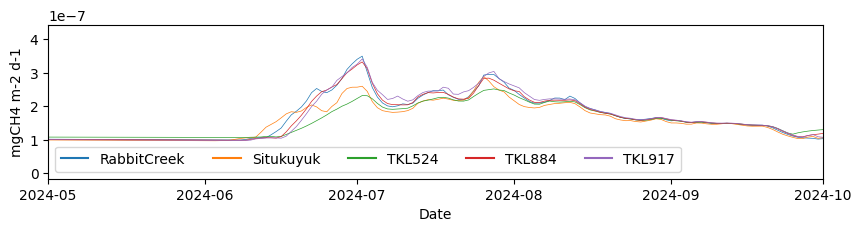

In [27]:
fig, ax = plt.subplots(figsize=(10,2))

sns.lineplot(data=methane.reset_index(), x='Date', y='methane_prod_young_mol/(m**2*s)', hue='site', linewidth=0.5)

ax.legend(ncol=5)
ax.set_ylabel('mgCH4 m-2 d-1')

plt.xlim(pd.to_datetime('2024-05-01'), pd.to_datetime('2024-10-01'))


In [28]:
duplicates = methane.duplicated(subset=['Date', 'site'], keep=False)
print(duplicates.sum())
if duplicates.sum() > 0:
    print(methane[duplicates].sort_values(['Date', 'site']).head())

0


Text(0, 0.5, 'mgCH4 m-2 d-1')

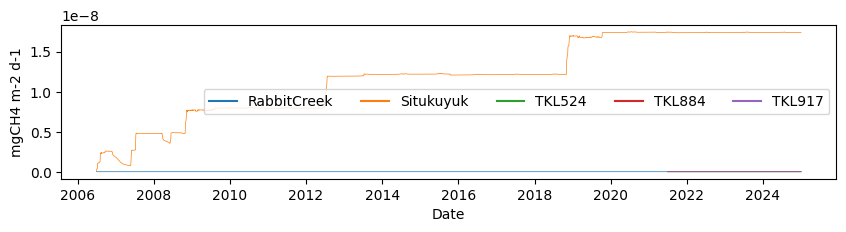

In [29]:
fig, ax = plt.subplots(figsize=(10,2))

sns.lineplot(data=methane, x='Date', y='methane_prod_old_mol/(m**2*s)', hue='site', linewidth=0.5)

ax.legend(ncol=5)
ax.set_ylabel('mgCH4 m-2 d-1')

#plt.xlim(pd.to_datetime('2024-05-01'), pd.to_datetime('2024-10-01'))

#### Calculate evaporation

In [30]:
latent_heat = latent_heat.merge(input_data[['Date', 'site', 'Temp']], on=['Date','site'], how='left')

In [31]:
latent_heat['lam'] = (2.501 - 0.00237 * latent_heat['Temp']) * 1e6

In [32]:
latent_heat['evap_kg/m2/s1'] = latent_heat['latent_heat_flux_W/m2'] / latent_heat['lam']
latent_heat['evap_kg/d'] = np.nan
latent_heat.loc[latent_heat['site']=='RabbitCreek', 'evap_kg/d'] = latent_heat.loc[latent_heat['site']=='RabbitCreek', 'evap_kg/m2/s1'] * 7600 * 86400
latent_heat.loc[latent_heat['site']=='Situkuyuk', 'evap_kg/d'] = latent_heat.loc[latent_heat['site']=='Situkuyuk', 'evap_kg/m2/s1'] * 1400 * 86400
latent_heat.loc[latent_heat['site']=='TKL524', 'evap_kg/d'] = latent_heat.loc[latent_heat['site']=='TKL524', 'evap_kg/m2/s1'] * 14700 * 86400
latent_heat.loc[latent_heat['site']=='TKL884', 'evap_kg/d'] = latent_heat.loc[latent_heat['site']=='TKL884', 'evap_kg/m2/s1'] * 16500 * 86400
latent_heat.loc[latent_heat['site']=='TKL917', 'evap_kg/d'] = latent_heat.loc[latent_heat['site']=='TKL917', 'evap_kg/m2/s1'] * 14000 * 86400

In [33]:
latent_heat_2024 = latent_heat[latent_heat['Date'].dt.year == 2024]

<Axes: xlabel='Date', ylabel='evap_kg/d'>

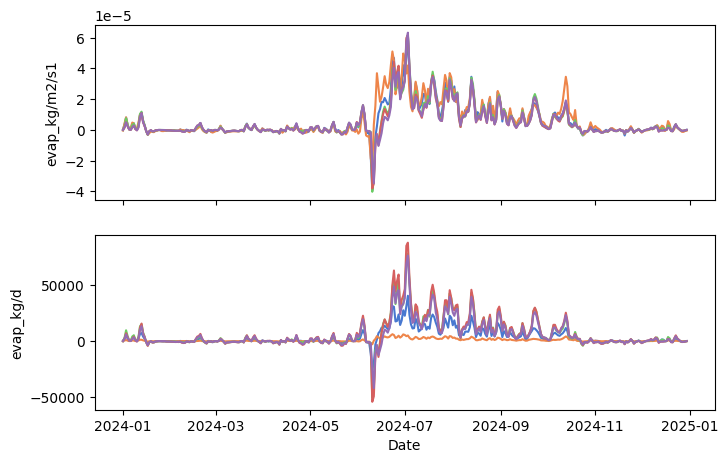

In [34]:
fig, axes = plt.subplots(2,1, figsize=(8,5), sharex=True)

sns.lineplot(data=latent_heat_2024, x='Date', y='evap_kg/m2/s1', hue='site', palette='muted', legend=False, ax=axes[0])
sns.lineplot(data=latent_heat_2024, x='Date', y='evap_kg/d', hue='site', palette='muted', legend=False, ax=axes[1])

In [35]:
latent_heat_2024 = latent_heat_2024[['site', 'Date', 'latent_heat_flux_W/m2', 'Temp', 'lam', 'evap_kg/m2/s1', 'evap_kg/d']]
latent_heat_2024 = latent_heat_2024.rename(columns = {'Temp': 'Tair_C', 'Date': 'date'})
latent_heat_2024 = latent_heat_2024.dropna()
latent_heat_2024.to_csv('data/Noatak_lakes_evaporation_2024.csv', index=False)
latent_heat_2024

,site,date,latent_heat_flux_W/m2,Tair_C,lam,evap_kg/m2/s1,evap_kg/d
6384,RabbitCreek,2024-01-01,1.138500,-14.534263,2.535446e+06,4.490334e-07,294.853284
6385,RabbitCreek,2024-01-02,8.867300,-9.399891,2.523278e+06,3.514199e-06,2307.563600
6386,RabbitCreek,2024-01-03,20.302000,-9.776315,2.524170e+06,8.043040e-06,5281.381993
6387,RabbitCreek,2024-01-04,8.252500,-19.253114,2.546630e+06,3.240557e-06,2127.879532
6388,RabbitCreek,2024-01-05,1.248900,-20.725950,2.550121e+06,4.897416e-07,321.583900
...,...,...,...,...,...,...,...
17307,TKL917,2024-12-26,0.004735,-24.003339,2.557888e+06,1.850980e-09,2.238946
17308,TKL917,2024-12-27,-1.452600,-29.465414,2.570833e+06,-5.650309e-07,-683.461329
17309,TKL917,2024-12-28,-1.264000,-31.750167,2.576248e+06,-4.906360e-07,-593.473323
17310,TKL917,2024-12-29,-0.771910,-35.921017,2.586133e+06,-2.984804e-07,-361.041913
